In [85]:
import math
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self.label = label
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    def sigmoid(self):
        out = Value(1.0 / ( 1.0 + math.exp(-self.data)), (self, ), "Sigmoid") 

        def _backward():
            self.grad += (out.data * (1 - out.data)) * out.grad
        out._backward = _backward
        return out

    def log(self):
        out = Value(math.log(self.data), (self, ), "Log")

        def _backward():
            self.grad += (1/self.data) * out.grad
        out._backward = _backward
        return out
    
    
    
    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"


In [91]:
import random
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, activation_function):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.activation_function = activation_function

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        if self.activation_function == 'relu':
            return act.relu()
        elif self.activation_function == 'sigmoid':
            return act.sigmoid()
        else:
            return act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        if self.activation_function == 'relu':
            return f"Relu Neuron({len(self.w)})"
        elif self.activation_function == 'sigmoid':
            return f"Sigmoid Neuron({len(self.w)})"
        else:
            return f"Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, activation_function):
        self.neurons = [Neuron(nin, activation_function) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts, activation_function):
        sz = [nin] + nouts
        #self.activation_function = activation_function
        if activation_function == 'sigmoid':
            self.layers = [Layer(sz[i], sz[i+1], activation_function=None if i != len(nouts) -1 else activation_function) for i in range(len(nouts))]
        else:
            self.layers = [Layer(sz[i], sz[i+1], activation_function=activation_function if i != len(nouts) -1 else None) for i in range(len(nouts))]


    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"


In [78]:
def binary_cross_entropy_loss(p, y_labels):
    N = len(y)
    total_loss = []
    for i in range(N):
        total_loss.append((y_labels[i] * (p[i].log())) + ((1-y_labels[i]) * (1 - p[i]).log()))
    return -1*(1/N) * sum(total_loss)
    
y = [0.92, 0.82, 0.69, 0.56, 0.47, 0.67, 0.93]
y = list(map(Value, y))
y_labels = [1, 0, 1, 0, 1, 1, 0]
y_labels= list(map(Value, y_labels))

loss = binary_cross_entropy_loss(y, y_labels)
loss.backward()
for v in y:
    print(v.grad)

for v in y_labels:
    print(v.grad)
#draw_dot(loss)

-0.15527950310559005
0.7936507936507935
-0.2070393374741201
0.3246753246753247
-0.303951367781155
-0.2132196162046908
2.0408163265306136
-0.34890671933845785
-0.21662106990972685
-0.11430275715887325
-0.03445172240241262
0.01716347312029476
-0.10116929398921232
-0.36952704915684903


In [67]:
import pandas as pd
import os

In [126]:
path_data = r"Dataset\assignment1_dataset.csv"

df = pd.read_csv(path_data)
x_inputs = list(zip(df['x1'], df['x2']))
y_labels = df['y']
print(x_inputs)


[(4.385900912179704, -2.792254207930033), (-5.443790260504329, -3.883680412396924), (1.7314430946324595, 2.013999476076321), (2.331427586005988, 3.264875092896011), (3.037739596912683, -1.432648431002174), (-6.002170461565541, -1.7627242563354446), (2.8239995946666614, -0.9237818298463992), (0.4339064550886922, -1.915022635252049), (-5.1999829357282215, -1.2822241097669629), (-6.418858534475908, -4.382074963249081), (1.001167230238293, -2.037198645136529), (-4.722920908348216, -2.4560212732442945), (0.9831833960444354, 1.2346209386706026), (-9.691408943575867, 4.394231130157543), (-0.2978548229319839, 2.4535803912808243), (-2.192051340664517, 3.0929881278844924), (4.022020131756916, 3.187783895665102), (3.0312717718802364, 2.6302834458814432), (1.0709753285063344, 3.0897954176926574), (-6.312568653734549, 3.612090703138727), (-0.6240716159612809, 3.9077957813479816), (3.486705710645828, 1.2174765443389428), (-1.4600018049211578, 4.356078476600837), (-3.301006014757531, 1.26152066113531

In [131]:
model = MLP(2, [5, 5, 1], activation_function='sigmoid')
print(model)
print("Number of parameters: ", len(model.parameters()))

MLP of [Layer of [Neuron(2), Neuron(2), Neuron(2), Neuron(2), Neuron(2)], Layer of [Neuron(5), Neuron(5), Neuron(5), Neuron(5), Neuron(5)], Layer of [Sigmoid Neuron(5)]]
Number of parameters:  51


In [ ]:
def loss(model, x_inputs, y_labels):
    # Put the inputs into a value object -> [N1 = (x1, x2), N2 = (x1, x2)]
    input = [list(map(Value, xrow)) for xrow in x_inputs]

    # Forward pass
    scores = list(map(model, input))

    # Calc the loss
    loss = binary_cross_entropy_loss(scores, y_labels) # Already summed loss of all the output of each input (x1, x2)
    accuracy = [(y_i > 0) == (score_i.data > 0) for y_i, score_i in zip(y_labels, scores)]
    acc = sum(accuracy) / len(accuracy)
    return loss, acc
loss(model, x_inputs, y_labels)

[(1.0, Value(data=0.9994963078435346, grad=0)), (0.0, Value(data=0.18294726131086644, grad=0)), (0.0, Value(data=0.2788914471050864, grad=0)), (0.0, Value(data=0.14079993213485414, grad=0)), (1.0, Value(data=0.9894907001330231, grad=0)), (0.0, Value(data=0.009772453268712147, grad=0)), (1.0, Value(data=0.9761442659589531, grad=0)), (1.0, Value(data=0.9143409794868059, grad=0)), (0.0, Value(data=0.012820781508541974, grad=0)), (0.0, Value(data=0.12647355265783425, grad=0)), (1.0, Value(data=0.9574413313700141, grad=0)), (0.0, Value(data=0.08029082585868973, grad=0)), (0.0, Value(data=0.30771972511598006, grad=0)), (1.0, Value(data=1.2847336040011843e-07, grad=0)), (0.0, Value(data=0.026082135927839464, grad=0)), (0.0, Value(data=0.0016823816333610456, grad=0)), (0.0, Value(data=0.5176672275602218, grad=0)), (0.0, Value(data=0.4227898575087764, grad=0)), (0.0, Value(data=0.05058075962159457, grad=0)), (1.0, Value(data=1.1631449186311054e-05, grad=0)), (0.0, Value(data=0.00333254454780568

(Value(data=0.10368640624505727, grad=0), 0.5)

In [135]:
learning_rate = 0.01

for k in range(50):

    total_loss, acc = loss(model, x_inputs, y_labels)
    print(acc)
    model.zero_grad()
    total_loss.backward()

    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

[(1.0, Value(data=0.9994963078435346, grad=0)), (0.0, Value(data=0.18294726131086644, grad=0)), (0.0, Value(data=0.2788914471050864, grad=0)), (0.0, Value(data=0.14079993213485414, grad=0)), (1.0, Value(data=0.9894907001330231, grad=0)), (0.0, Value(data=0.009772453268712147, grad=0)), (1.0, Value(data=0.9761442659589531, grad=0)), (1.0, Value(data=0.9143409794868059, grad=0)), (0.0, Value(data=0.012820781508541974, grad=0)), (0.0, Value(data=0.12647355265783425, grad=0)), (1.0, Value(data=0.9574413313700141, grad=0)), (0.0, Value(data=0.08029082585868973, grad=0)), (0.0, Value(data=0.30771972511598006, grad=0)), (1.0, Value(data=1.2847336040011843e-07, grad=0)), (0.0, Value(data=0.026082135927839464, grad=0)), (0.0, Value(data=0.0016823816333610456, grad=0)), (0.0, Value(data=0.5176672275602218, grad=0)), (0.0, Value(data=0.4227898575087764, grad=0)), (0.0, Value(data=0.05058075962159457, grad=0)), (1.0, Value(data=1.1631449186311054e-05, grad=0)), (0.0, Value(data=0.00333254454780568

In [3]:

import os

# Voeg de map van 'dot' toe aan PATH binnen Python
os.environ["PATH"] += os.pathsep + "/opt/local/bin"

# Daarna pas graphviz gebruiken
from graphviz import Digraph

In [4]:
def trace(root):
    # build a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={"rankdir": "LR"}) # LR is left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectengular node for it

        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4r }" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            # if this value is a result of some operation then create a op node 
            dot.node(name = uid + n._op, label = n._op)
            # and connect the node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

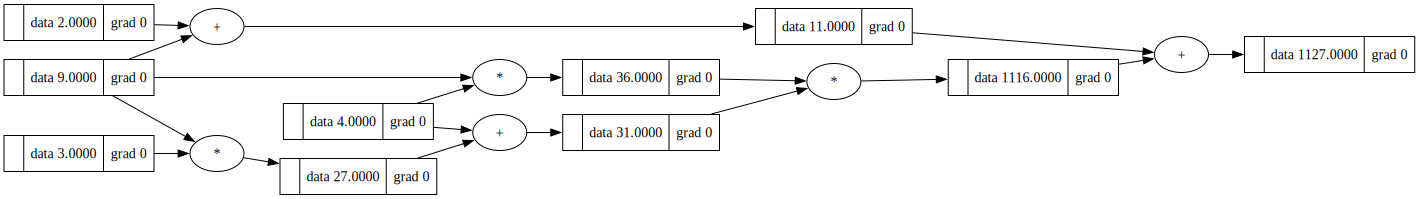

In [5]:
a = Value(2)
b = Value(9)
c = Value(4)
d = Value(3)
e = Value(3)
f = Value(6)
x1 = a + b
x2 = b * c
x3 = c + b * d
x4 = e + f
o = x1 + x2 * x3
draw_dot(o)

In [18]:
8 * math.log(1-0)

0.0

In [90]:
a = Value(2)
print(a.sigmoid())

Value(data=0.8807970779778823, grad=0)


MLP of [Layer of [Sigmoid Neuron(3), Sigmoid Neuron(3), Sigmoid Neuron(3), Sigmoid Neuron(3), Sigmoid Neuron(3)], Layer of [Sigmoid Neuron(5), Sigmoid Neuron(5), Sigmoid Neuron(5), Sigmoid Neuron(5), Sigmoid Neuron(5)], Layer of [Neuron(5)]]


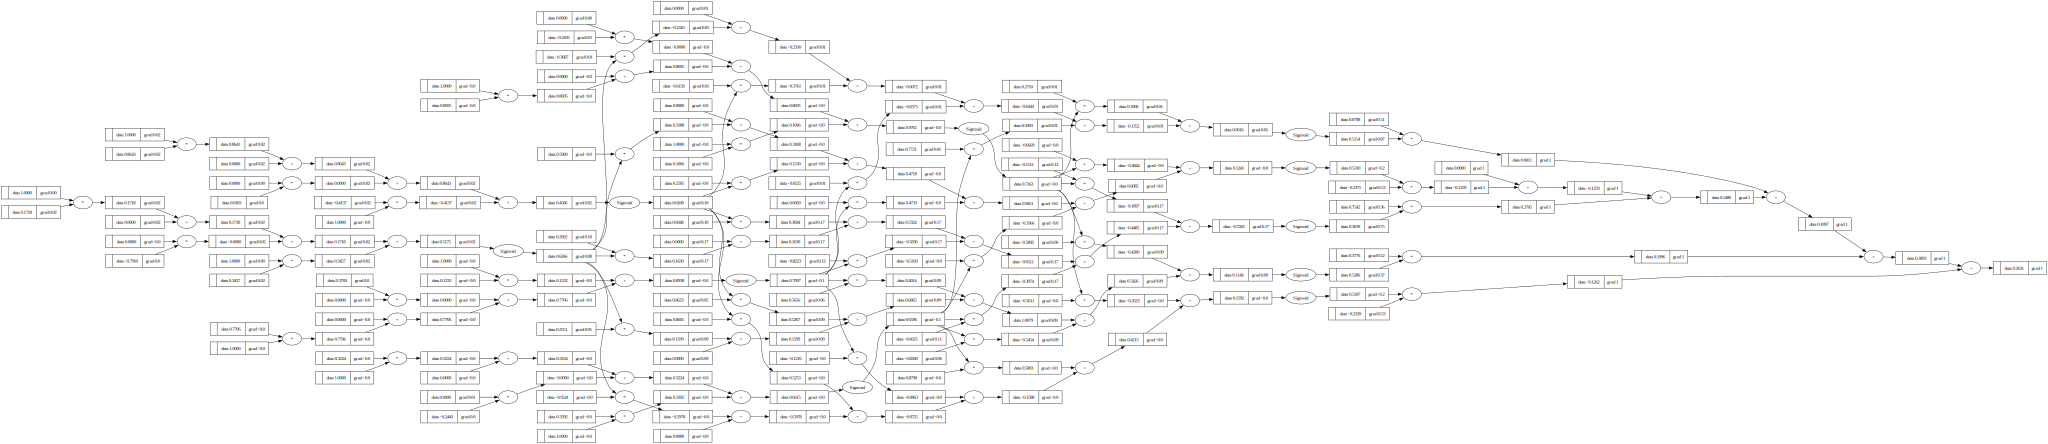

In [21]:
nn = MLP(3, [5, 5, 1], activation_function='sigmoid')
#nn = Layer(3, 1, activation_function=None)
data = [1.0, 0.0, 1.0]
model = nn(data)
print(nn)
model.backward()
draw_dot(model)